# Time Integration of Chemical Reactor Networks Using DifferentialEquation.jl

## Import Package

In [3]:
using LinearAlgebra
using DifferentialEquations
using Plots 

## Section 1: Introduction

### Context 

The numerical simulation of turbulent non-premixed combustion in industrial furnaces to access measures to combat pollutant formation is computationally costly. Measures include: new fuels (mixture with hydrogen gas, ammonia, synthetic gas), alternative oxidizers (pure oxygen instead of ambient air) and new fuel injection system (staged injection, flameless combustion). 

Numerical simulation can be carried out in two stage: 
1. In first stage a computational fluid dynamics model with reduced or skeleton reduction mechanism is solved. The goal of this first stage is to sufficiently accurately predict the flow, density, temperature and radiative intensity fields. In the first stage, major chemical species are of concern. Minor chemical species are not.
2. In second stage a chemical reaction network with detailed chemical reaction mechanism is solved. The flow field is frozen. A detailed chemical reaction mechanism is employed. 

### Goals 

The goal of the project is to explore advanced numerical methods to solve large scale chemical reaction networks in the post-processing stage of a computational fluid dynamics model for chemically reaction flow. These advanced numerical methods include implicit time-integration for stiff ordinary differential equations, operator splitting method (splitting the diffusive, convective and reactive part of the right-hand side of the ordinary differential equastions), automatic differentiation to generate the Jacobian.      

### Documentation 
Documentation of `DifferentialEquations.jl`
<ul>
<li> <a href="https://docs.sciml.ai/DiffEqDocs/stable/tutorials/ode_example/"> Examples </a>   
<li> <a href="https://diffeq.sciml.ai/stable/"> Documentation of DifferentialEquations.jl on Github </a>  
<li> <a href="https://diffeq.sciml.ai/dev/features/performance_overloads/#Function-Type-Definitions"> Specifying Jacobian types using DifferentialEquations.jl </a>   
</ul>   

Documentation of `ModelingToolkit.jl` (for handling ODEs depending on parameters)
<ul>
<li> <a href="https://mtk.sciml.ai/stable/"> Documentation of ModelingToolkit.jl on Github </a>    
</ul> 

Documentation of `Catalist.jl` (for chemical reaction mechanisms)
<ul>
<li> <a href="https://catalyst.sciml.ai/stable/"> Documentation of Catalist.jl</a>    
</ul> 

Documentation of `ReactionMechanismSimulator.jl` (again for chemical reaction mechanisms)
<ul>
<li> <a href="https://docs.sciml.ai/ReactionMechanismSimulator/stable/"> Documentation of ReactionMechanismSimulator.jl</a>    
</ul>

Documentation on GRI-30 mechanism (as example of a chemical reaction mechanism)
<ul>
<li> <a href="https://cantera.org/tutorials/python-tutorial.html"> GRI30.xml </a>  
<li> <a href="https://discourse.julialang.org/t/calling-chemical-kinetics-solvers-like-chemkin-or-cantera-from-julia/50568/2"> Reading mechanism into Julia</a> (using Python interface to Cantera) 
</ul>

## Section 2: Single Seperable ODE Example with Linear Right-Hand Side 

This example was taken from https://docs.sciml.ai/DiffEqDocs/stable/tutorials/ode_example/#Example-1-:-Solving-Scalar-Equations For this example, a reference solution can be constructed using seperation of variables (or using sympy, or wolframalpha). We also plot the time-step evoution.

In this example we solve
$$
\frac{du}{dt} = f(u,p,t) = 1.01 \, u 
$$

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


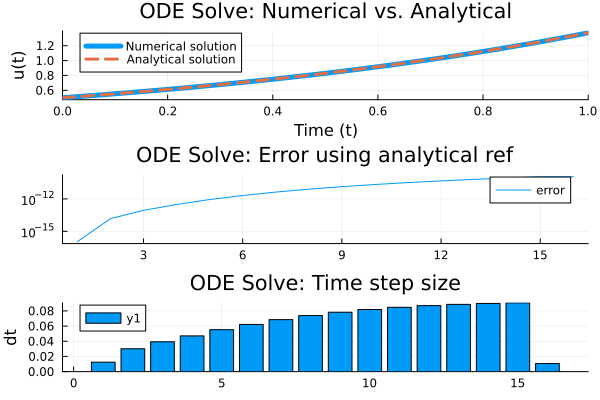

In [4]:
# problem set-up: set driving function 
f(u,p,t) = 1.01*u
# problem set-up: set initial guess 
u0=1/2
# problem set-up: set the time span 
tspan = (0.0,1.0)
# set ODE function (not strictly necessary at this stage)
ff = ODEFunction(f)
# problem set-up: define the ODE problem 
prob = ODEProblem(ff,u0,tspan)

# perform time integration 
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

#sol = solve(prob,Tsit5())

# compute the time step 
dt = collect(sol.t[i+1]-sol.t[i] for i in 1:length(sol.t)-1) # same as a list comprehension

sampled = collect(0.5*exp(1.01t) for t in sol.t) # analytical solution

merror = abs.(sol.u - sampled)

# plot numerical and analytical solution 
p1=plot(sol,linewidth=5,title="ODE Solve: Numerical vs. Analytical",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical solution") # legend=false

p1=plot!(sol.t, t->0.5*exp(1.01t),lw=3,ls=:dash,label="Analytical solution");

p2=plot(merror[2:end], yaxis=:log, label="error", title="ODE Solve: Error using analytical ref");

p3=bar(dt,yaxis="dt", title="ODE Solve: Time step size"); 

plot(p1,p2,p3,layout=(3,1))

In [5]:
display(prob);

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


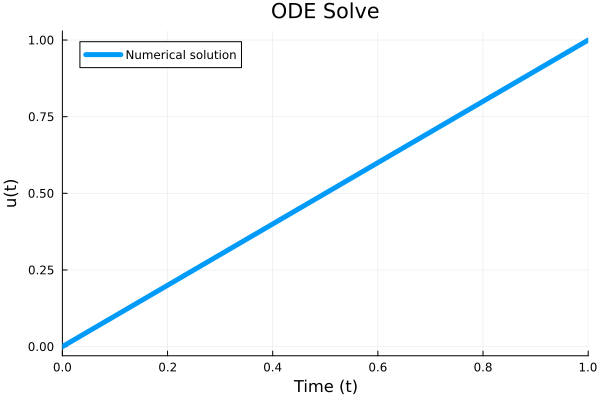

In [6]:
# problem set-up: set driving function 
f(u,p,t) = 1.
# problem set-up: set initial guess 
u0=0 
# problem set-up: set the time span 
tspan = (0.0,1.0)
# set ODE function (not strictly necessary at this stage)
ff = ODEFunction(f)
# problem set-up: define the ODE problem 
prob = ODEProblem(ff,u0,tspan)

# perform time integration 
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

# plot numerical and analytical solution 
p1=plot(sol,linewidth=5,title="ODE Solve",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical solution") 

## Section 3: Single Seperable ODE Example with Non-Linear Right-Hand Side 

In this example, the analytical reference solution can still be found using seperation of variables (or using sympy or wolframpalpha). 

In this example we solve
$$
\frac{du}{dt} = f(u,p,t) = 1.01 \, u^2 
$$

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


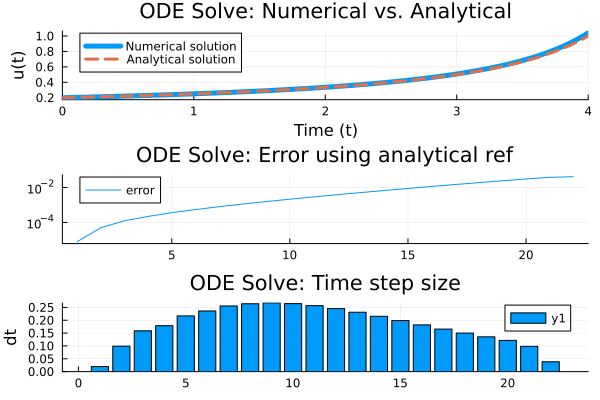

In [7]:
# problem set-up: set driving function 
f(u,p,t) = 1.01*u*u
# problem set-up: set initial guess 
u0=1/5
# problem set-up: set the time span 
tspan = (0.0,4.0)
# set ODE function (not strictly necessary at this stage)
ff = ODEFunction(f)
# problem set-up: define the ODE problem 
prob = ODEProblem(ff,u0,tspan)

# perform time integration 
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)
# sol = solve(prob,Tsit5())

# compute the time step 
dt = collect(sol.t[i+1]-sol.t[i] for i in 1:length(sol.t)-1)
sampled = collect(1/(5-t) for t in sol.t)
merror = abs.(sol.u - sampled)

# plot numerical and analytical solution 
p1=plot(sol,linewidth=5,title="ODE Solve: Numerical vs. Analytical",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical solution") # legend=false

p1=plot!(sol.t, t->1/(5-t),lw=3,ls=:dash,label="Analytical solution");

p2=plot(merror[2:end], yaxis=:log, label="error", title="ODE Solve: Error using analytical ref");

p3=bar(dt,yaxis="dt", title="ODE Solve: Time step size"); 

plot(p1,p2,p3,layout=(3,1))

### Section 1.3: Same example as before using in-place function for right-hand side function

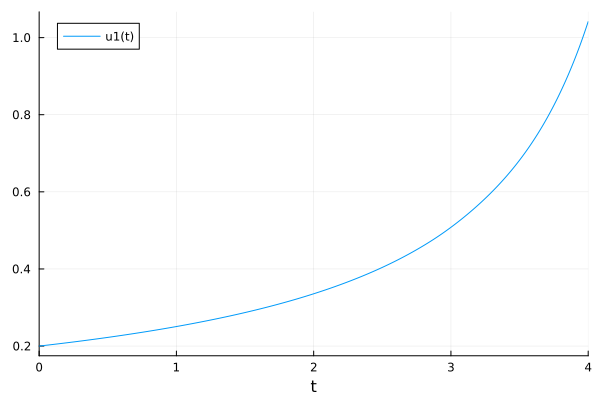

In [8]:
function f!(du,u,p,t)
# observe that specifying first component of u is required here
    du[1] = 1.01*u[1]*u[1]
end 

# observe that specifying u0 as a vector is required here 
u0 = [.2];

tspan = (0.,4.)
prob = ODEProblem(f!,u0,tspan)

sol = solve(prob)

plot(sol)

### Section 2.3: Same example as before using Jacobian function

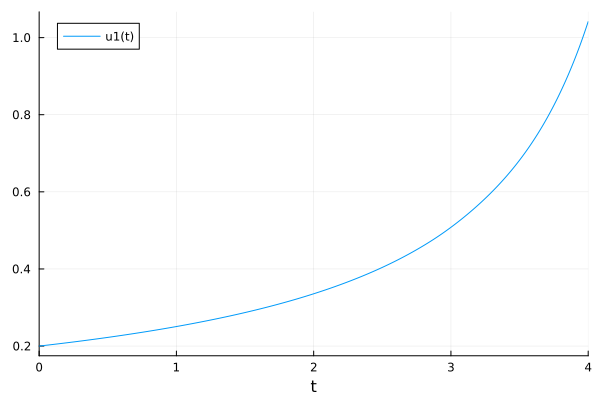

In [9]:
function f!(du,u,p,t)
# observe that specifying first component of u is required here
    du[1] = 1.01*u[1]*u[1]
end 

function j!(J,u,p,t)
# observe that specifying first component of u is required here
    J[1,1] = 2.02*u[1]
end 

# observe that specifying u0 as a vector is required here 
u0 = [.2];

# include jacobian in ODEFunction
ff = ODEFunction(f!, jac=j!)

tspan = [0.,4.]
prob = ODEProblem(ff,u0,tspan)

sol = solve(prob)

plot(sol,idx=(1))

## Section 4: Coupled System Example: Single Step Mechanism 

In [10]:
function methane!(du,u,p,t)
 k = 0.5 
 du[1] = -k*u[1]*u[2]*u[2]
 du[2] = -k*u[1]*u[2]*u[2]
 du[3] = k*u[1]*u[2]*u[2]
 du[4] = k*u[1]*u[2]*u[2]
end

methane! (generic function with 1 method)

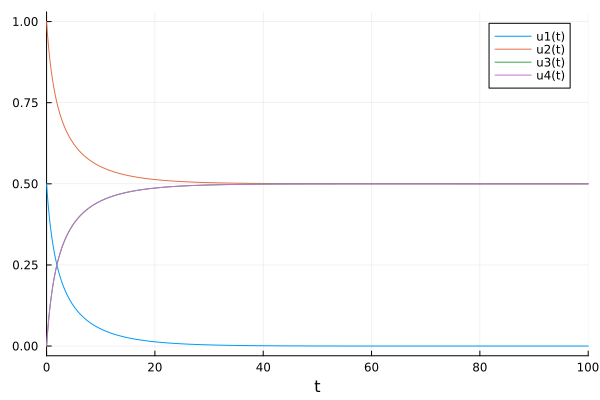

In [11]:
u0 = [0.5;1.0;0.0;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(methane!,u0,tspan)
sol = solve(prob)
plot(sol,idxs=1)
plot!(sol,idxs=2)
plot!(sol,idxs=3)
plot!(sol,idxs=4)

## References 

1. Master Thesis [Rishikesh Sampat](https://repository.tudelft.nl/islandora/object/uuid%3A5297cc7d-cf15-4fc4-9ba4-bce2290cc85c?collection=education). Good intro into chemical reactor networks. 

2. Master Thesis [Pratik Sukar](https://repository.tudelft.nl/islandora/object/uuid%3Ab56a1cc5-78bd-43b1-9f98-7c3a868da595?collection=education). See research questions. 

3. Bachelor Thesis [Bowen Zhu](https://repository.tudelft.nl/islandora/object/uuid%3A9fecf847-3a86-4da6-9f21-f1714bb90dcc?collection=education). First steps in Julia implementation. 

4. Bachelor Thesis [Jochem van der Meer](https://repository.tudelft.nl/islandora/object/uuid%3Af458f0cb-545f-4744-b621-870da7498cb1?collection=education). Continuation of work of Bowen Zhu. 

5. Numerical Recipies - [Section 17.5: Stiff Ordinary Differential Equation](http://numerical.recipes/book.html)

6. Kee, Coltrin, Glarborg - [Chemically Reacting Flow: Theory and Practise](https://www.google.nl/books/edition/Chemically_Reacting_Flow/-t9zaKNskyMC?hl=en&gbpv=0)